In [29]:
!pip install catboost

In [30]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn import base
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
import lightgbm as lgb
import itertools
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_recall_curve
from collections import defaultdict 
from sklearn.metrics import f1_score, classification_report
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import TimeSeriesSplit
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from feature_engine.encoding import WoEEncoder
from sklearn.preprocessing import TargetEncoder
import scipy.stats as stats
from utils import *
from sklearn.multiclass import OneVsRestClassifier
#from embedding_encoder import EmbeddingEncoder
import sys
import numpy
from collections import Counter 
from sklearn.preprocessing import TargetEncoder

In [31]:
df = pd.read_csv("train_new_feats.csv")

In [32]:
target = [[f"target_{i}" for i in range(1, 9)] + ["Claim Injury Type"] + ["WCB Decision"] + ["Agreement Reached"] + ["Claim Injury Type_encoded"]]
target = [item for sublist in target for item in sublist]
target

binary_target = [f"target_{i}" for i in range(1, 9)]

original_target  = [col for col in target if col not in binary_target]

ordinal_target = ["Claim Injury Type_encoded"]

features = [feat for feat in df.columns if feat not in target]

features = [feat for feat in features if df[feat].dtype != "datetime64[ns]"]

num_feats = [feat for feat in features if df[feat].dtype != "object"]

cat_feats = [feat for feat in features if df[feat].dtype == "object"]
cat_feats_index = [features.index(feat) for feat in cat_feats]


In [ ]:
def frequency_encoding(train_df, val_df, column):
    """
    Apply frequency encoding on the training set and use the same encoding to impute the validation set.
    
    Parameters:
    train_df (pd.DataFrame): Training dataset.
    val_df (pd.DataFrame): Validation dataset.
    column (str): Column to encode.
    
    Returns:
    train_encoded (pd.DataFrame): Encoded training set.
    val_encoded (pd.DataFrame): Encoded validation set.
    freq_map (dict): Mapping of frequency counts for the column.
    """
    # Compute frequency encoding for the training set
    freq_map = train_df[column].value_counts(normalize=True)  # Relative frequency
    train_df[f"{column}_freq"] = train_df[column].map(freq_map)

    # Impute frequency encoding on the validation set using the same mapping
    val_df[f"{column}_freq"] = val_df[column].map(freq_map)

    # Handle unseen categories in validation by imputing 0 frequency
    val_df[f"{column}_freq"] = val_df[f"{column}_freq"].fillna(0)
    
    train_df = train_df.drop(columns=[column])
    val_df = val_df.drop(columns=[column])

    # Return encoded datasets and frequency map
    return train_df, val_df, freq_map

In [33]:
def target_guided_ordinal_encoding(X_train, X_val, categorical_column, target_column, y_train, i):
    # Combine X_train with y_train temporarily to calculate means
    X_train_encoded = X_train.copy()
    X_val_encoded = X_val.copy()
    X_train_encoded[target_column] = y_train

    means = X_train_encoded.groupby(categorical_column)[target_column].mean()
    #print(means)

    sorted_means = means.sort_values(by=target_column)
    #print(sorted_means)
    # if i == 1:
    #     print(f"Showing sorted means for {categorical_column}")
    #     lst_names = sorted_means.index.tolist()
    #     lst_values = sorted_means.values.tolist()
    #     dict_final = dict(zip(lst_names, lst_values))
    #     print(dict_final)
    
    ordinal_mapping = {category: rank for rank, category in enumerate(sorted_means.index, start=1)}
    # if i == 1:
    #     print(f"Showing ordinal mapping for {categorical_column}")
    #     print(ordinal_mapping)
    #     print("--------------------------------")
        
    X_train_encoded[f"{categorical_column}_encoded"] = X_train_encoded[categorical_column].map(ordinal_mapping)
    X_val_encoded[f"{categorical_column}_encoded"] = X_val_encoded[categorical_column].map(ordinal_mapping)

    #X_train_encoded = X_train_encoded.drop(columns=[categorical_column])
    X_train_encoded = X_train_encoded.drop(columns=[target_column[0]])
    #X_val_encoded = X_val_encoded.drop(columns=[categorical_column])
    X_train_encoded = X_train_encoded.fillna(1)
    X_val_encoded = X_val_encoded.fillna(1)

    return X_train_encoded, X_val_encoded, ordinal_mapping


In [34]:
# AUXILIARY FUNCTION FOR REDUDANT FEATURE REMOVAL

def cross_corr_mean(df_input, corr_coeff=0.95):
    # adjusted from: https://github.com/adityav95/variable_reduction_correlation/blob/master/variable_reduction_by_correlation.ipynb
    # in the original they used pearson correlation here we use spearman
	""" The function retuns a list of features to be dropped from the input features.
	
	INPUTS:
	1. df_input: n input features (pandas dataframe)
	2. corr_coeff: Coefficient threshold (absolute value, no negatives) for a pair of variables above which one of the two will be dropped
	
	NOTICE:
	- The dataframe df_input (should contain only the n input features i.e. no ID and targets) 
	
	SUMMARY OF LOGIC:
	1. The n input variables are taken and a n X n matrix of correlation is created (these are absolute values i.e. a correlation of -0.8 is treated as 0.8)
	2. Variable pairs with correlation higher than the corr_coeff threshold are picked and one of the two variables will be dropped
	3. Which of the two will be dropped is based on the one having lower mean absolute correlation with all other variables 

	"""


	# Generating correlation matrix of input features
	corr_matrix = df_input.corr(method = 'spearman')

	# Generating correlation with the target
	corr_mean = abs(corr_matrix).mean()

	# Preparing data
	features_drop_list = [] # This will contain the list of features to be dropped
	features_index_drop_list = [] # This will contain the index of features to be dropped as per df_input
	corr_matrix = abs(corr_matrix)

	# Selecting features to be dropped (Using two for loops that runs on one triangle of the corr_matrix to avoid checking the correlation of a variable with itself)
	for i in range(corr_matrix.shape[0]):
		for j in range(i+1,corr_matrix.shape[0]):

			# The following if statement checks if each correlation value is higher than threshold (or equal) and also ensures the two columns have NOT been dropped already.  
			if corr_matrix.iloc[i,j]>=corr_coeff and i not in features_index_drop_list and j not in features_index_drop_list:
			
				# The following if statement checks which of the 2 variables with high correlation has a lower correlation with target and then drops it. If equal we can drop any and it drops the first one (This is arbitrary)
				if corr_mean[corr_matrix.columns[i]] >= corr_mean[corr_matrix.columns[j]]:
					features_drop_list.append(corr_matrix.columns[i])	# Name of variable that needs to be dropped appended to list
					features_index_drop_list.append(i)	# Index of variable that needs to be dropped appended to list. This is used to not check for the same variables repeatedly
				else:
					features_drop_list.append(corr_matrix.columns[j])
					features_index_drop_list.append(j)

	return features_drop_list





In [35]:
np.random.seed(42)
data = {
    'A': [1, 2, 3, 4, 5, 4, 7, 8, 9, 10],               
    'B': np.random.randint(10, 100, 10),      
    'C': np.random.randint(20, 50, 10),  
    'D': np.arange(1, 11) * 0.98         
}
ex = pd.DataFrame(data)

print("The correlation between A and D is:", ex["A"].corr(ex["D"], method='spearman'))

corr_matrix = ex.corr(method='spearman')
print("\nThe mean correlation for each column with all other columns is:")
print(abs(corr_matrix).mean()) 


print("\nThe features to be dropped is D it correlates more with the other variables (0.71 > 0.67):")
features_to_drop = cross_corr_mean(ex, corr_coeff=0.95)
print(features_to_drop)


The correlation between A and D is: 0.978727925324904

The mean correlation for each column with all other columns is:
A    0.673814
B    0.690922
C    0.346266
D    0.713593
dtype: float64

The features to be dropped is D it correlates more with the other variables (0.71 > 0.67):
['D']


In [36]:
from sklearn.preprocessing import TargetEncoder
n_splits = 3
stratified_kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
feat_sel_results = []

def frequency_encoding(train_df, val_df, column):
    """
    Apply frequency encoding on the training set and use the same encoding to impute the validation set.
    
    Parameters:
    train_df (pd.DataFrame): Training dataset.
    val_df (pd.DataFrame): Validation dataset.
    column (str): Column to encode.
    
    Returns:
    train_encoded (pd.DataFrame): Encoded training set.
    val_encoded (pd.DataFrame): Encoded validation set.
    freq_map (dict): Mapping of frequency counts for the column.
    """
    # Compute frequency encoding for the training set
    freq_map = train_df[column].value_counts(normalize=True)  # Relative frequency
    train_df[f"{column}_freq"] = train_df[column].map(freq_map)

    # Impute frequency encoding on the validation set using the same mapping
    val_df[f"{column}_freq"] = val_df[column].map(freq_map)

    # Handle unseen categories in validation by imputing 0 frequency
    val_df[f"{column}_freq"] = val_df[f"{column}_freq"].fillna(0)
    
    train_df = train_df.drop(columns=[column])
    val_df = val_df.drop(columns=[column])

    # Return encoded datasets and frequency map
    return train_df, val_df, freq_map

In [37]:
def target_guided_ordinal_encoding(X_train, X_val, categorical_column, target_column, y_train, i):
    # Combine X_train with y_train temporarily to calculate means
    X_train_encoded = X_train.copy()
    X_val_encoded = X_val.copy()
    X_train_encoded[target_column] = y_train

    means = X_train_encoded.groupby(categorical_column)[target_column].mean()
    #print(means)

    sorted_means = means.sort_values(by=target_column)
    #print(sorted_means)
    # if i == 1:
    #     print(f"Showing sorted means for {categorical_column}")
    #     lst_names = sorted_means.index.tolist()
    #     lst_values = sorted_means.values.tolist()
    #     dict_final = dict(zip(lst_names, lst_values))
    #     print(dict_final)
    
    ordinal_mapping = {category: rank for rank, category in enumerate(sorted_means.index, start=1)}
    # if i == 1:
    #     print(f"Showing ordinal mapping for {categorical_column}")
    #     print(ordinal_mapping)
    #     print("--------------------------------")
        
    X_train_encoded[f"{categorical_column}_encoded"] = X_train_encoded[categorical_column].map(ordinal_mapping)
    X_val_encoded[f"{categorical_column}_encoded"] = X_val_encoded[categorical_column].map(ordinal_mapping)

    #X_train_encoded = X_train_encoded.drop(columns=[categorical_column])
    X_train_encoded = X_train_encoded.drop(columns=[target_column[0]])
    #X_val_encoded = X_val_encoded.drop(columns=[categorical_column])
    X_train_encoded = X_train_encoded.fillna(1)
    X_val_encoded = X_val_encoded.fillna(1)

    return X_train_encoded, X_val_encoded, ordinal_mapping


In [38]:
np.random.seed(1)
data = {
    'Gender': np.random.choice(['Male', 'Female', "Other"], 30),               # Gender (categorical)
    'Eye_Color': np.random.choice(['Blue', 'Green', 'Brown'], 30),    # Eye Color (categorical)
    'Marital_Status': np.random.choice(['Single', 'Married'], 30),    # Marital Status (categorical)
    'y': np.random.randint(1, 3, 30)                                  # Continuous integer (1-3)
}
ex = pd.DataFrame(data)

cat_cols = ex.select_dtypes(include=["object"]).columns.tolist()
ex_train = ex[cat_cols][:20]
ex_val = ex[cat_cols][20:]
y_train = ex[["y"]][:20]

for cat in cat_cols:
    ex_train, ex_val, mapping = target_guided_ordinal_encoding(ex_train, ex_val, cat, ["y"], y_train, 1)

In [39]:
def num_imputing(X_train, X_val):
    feats_imput_max = ["C2_Accident_gap_weeks", "C3_Accident_gap_weeks", "Accident Date_assembly_gap_days", "Hearing_C3 gap_months", "Hearing_C2 gap_months", "Hearing_assembly_gap_months", "Days to First Hearing"]

    feat_imput_min = ["C3-C2_gap_days"]
    
    for feat in X_train.columns:
        if X_train[feat].isna().sum() > 0:
            if feat in feats_imput_max:
                X_train[feat] = X_train[feat].fillna(X_train[feat].max())
                X_val[feat] = X_val[feat].fillna(X_train[feat].max())
            elif feat in feat_imput_min:
                X_train[feat] = X_train[feat].fillna(X_train[feat].min())
                X_val[feat] = X_val[feat].fillna(X_train[feat].min())
            else:
                X_train[feat] = X_train[feat].fillna(X_train[feat].mean())
                X_val[feat] = X_val[feat].fillna(X_train[feat].mean())
    return X_train, X_val


# Feature Selection

In [40]:
X= df[features]
X.columns

Index(['Age at Injury', 'Alternative Dispute Resolution',
       'Attorney/Representative', 'Carrier Name', 'Carrier Type',
       'County of Injury', 'COVID-19 Indicator', 'District Name', 'Gender',
       'IME-4 Count', 'Industry Code Description', 'Medical Fee Region',
       'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description',
       'WCIO Part Of Body Description', 'Zip Code', 'Number of Dependents',
       'Accident Date_year', 'Accident Date_missing', 'Accident_weekend',
       'Accident Date_month_cos', 'Accident Date_month_sin',
       'Accident Date_quarter_cos', 'Accident Date_quarter_sin',
       'Accident Date_assembly_gap_days', 'C3-C2_gap_days', 'C2_missing',
       'C3_missing', 'C2_Accident_gap_weeks', 'C3_Accident_gap_weeks',
       'Hearing Date_missing', 'Hearing_C3 gap_months',
       'Hearing_C2 gap_months', 'Hearing_assembly_gap_months',
       'Days to Assembly', 'Days to First Hearing', 'Days from COVID',
       'Age_not_correct', 'Average W

In [41]:
y_ordinal = df[ordinal_target]
y_ordinal

,Claim Injury Type_encoded
0,1.0
1,3.0
2,3.0
3,1.0
4,2.0
...,...
574021,1.0
574022,1.0
574023,3.0
574024,1.0


Initializing CV_1/3...
Ordinal encoding...


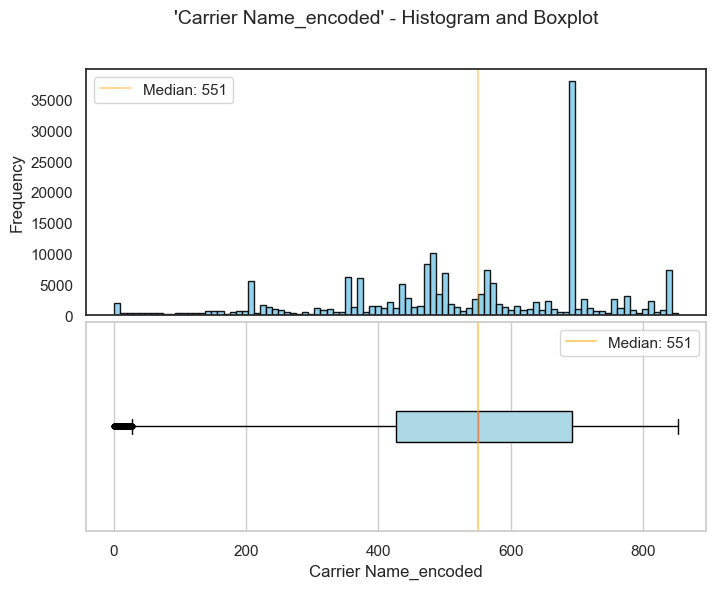

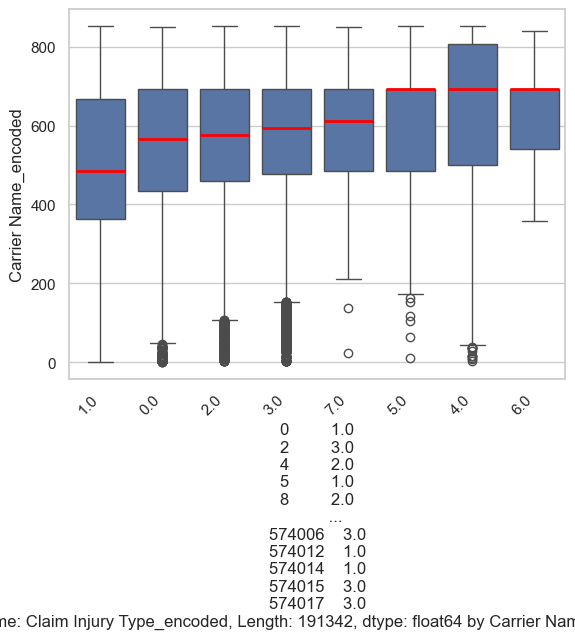

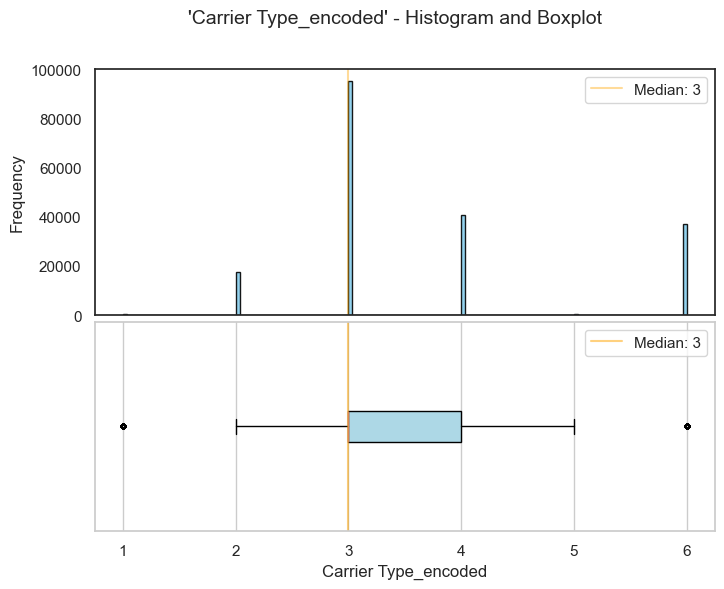

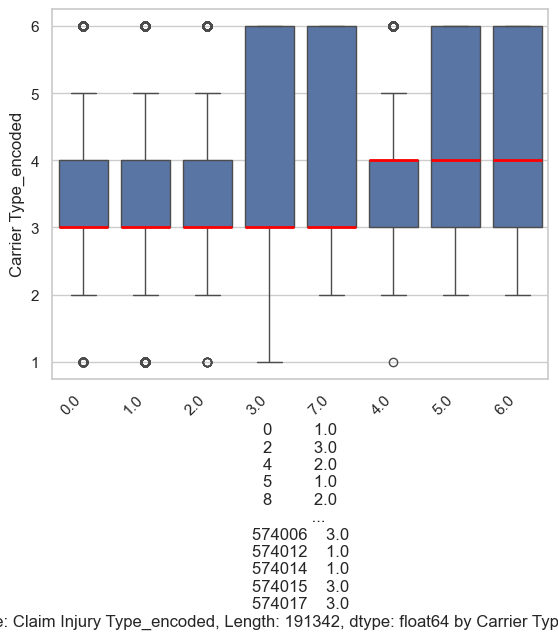

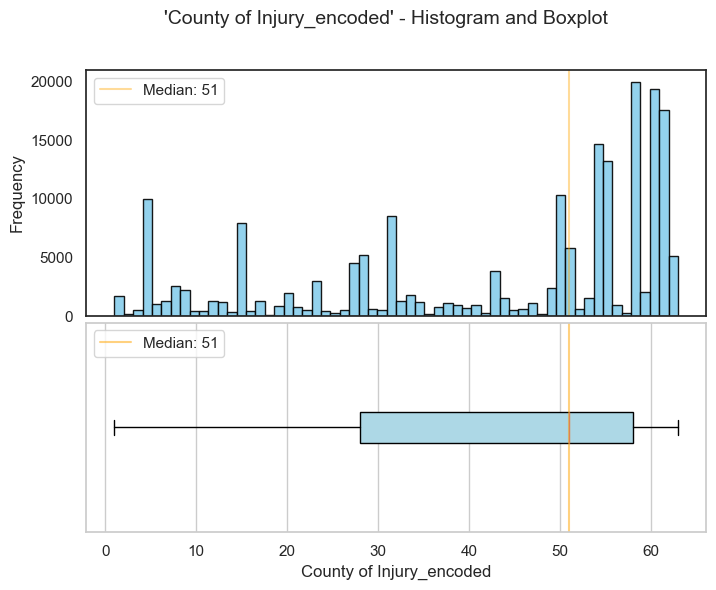

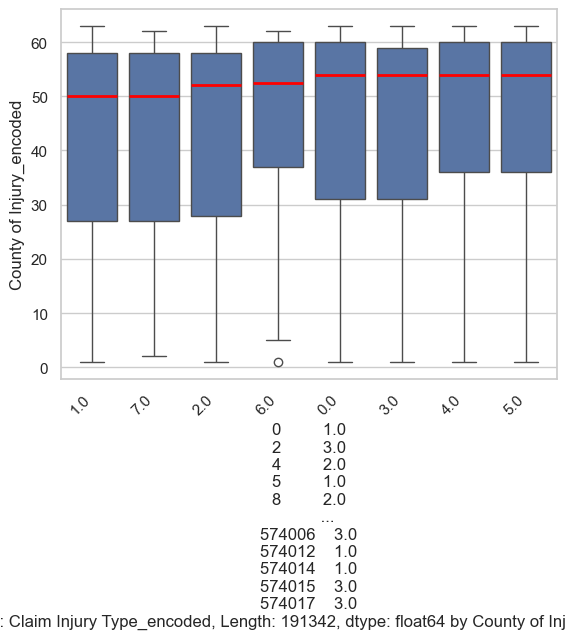

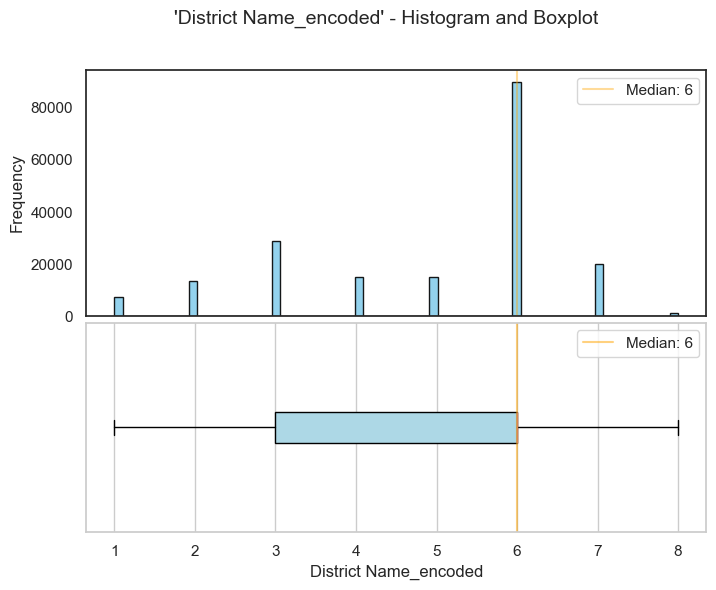

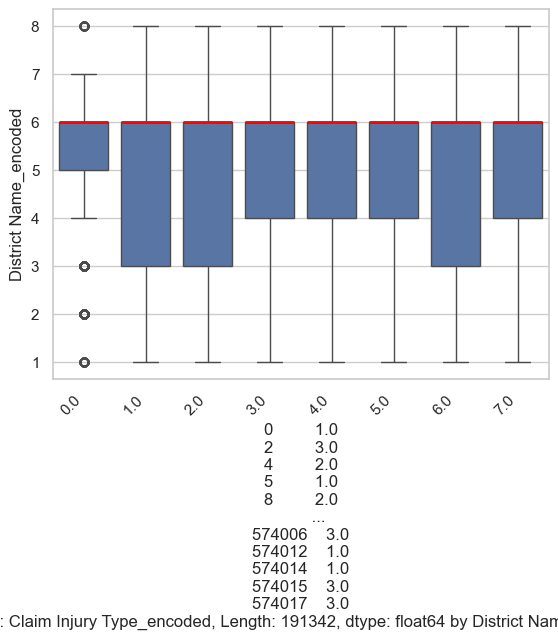

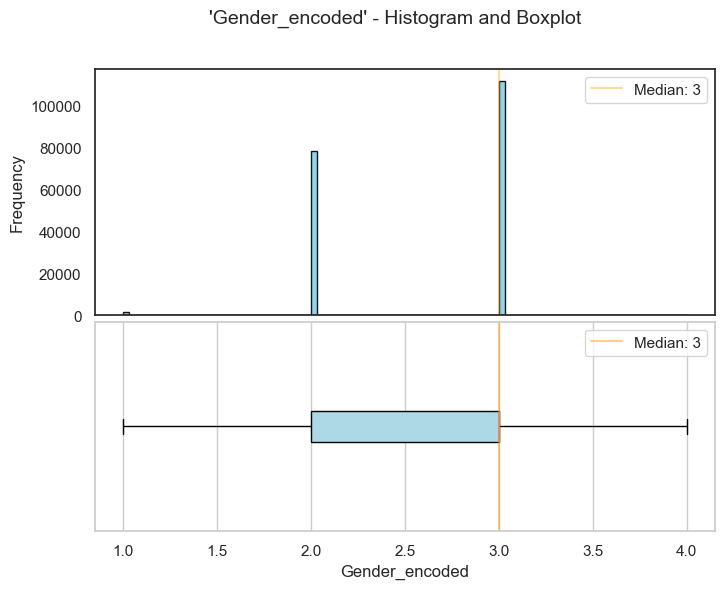

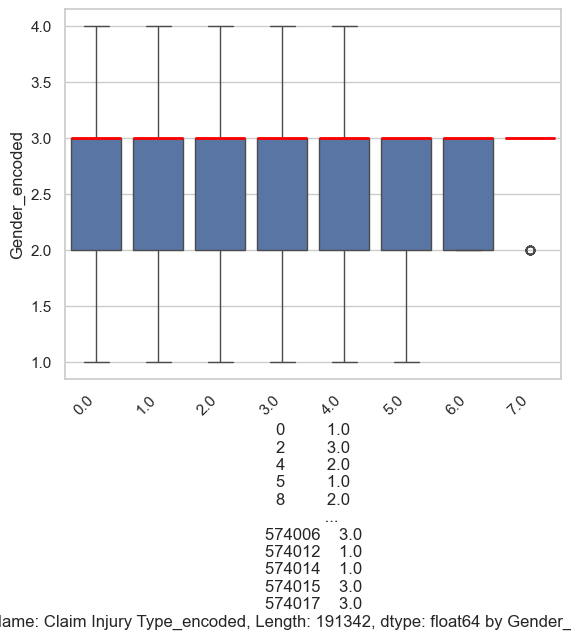

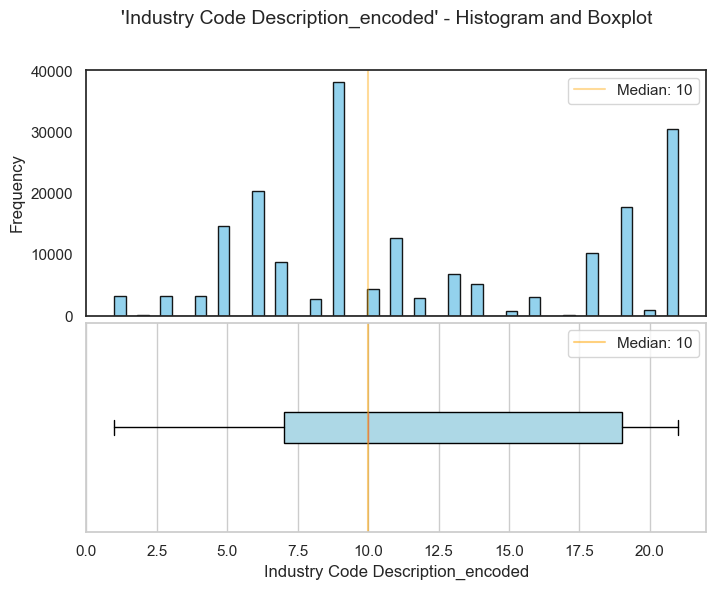

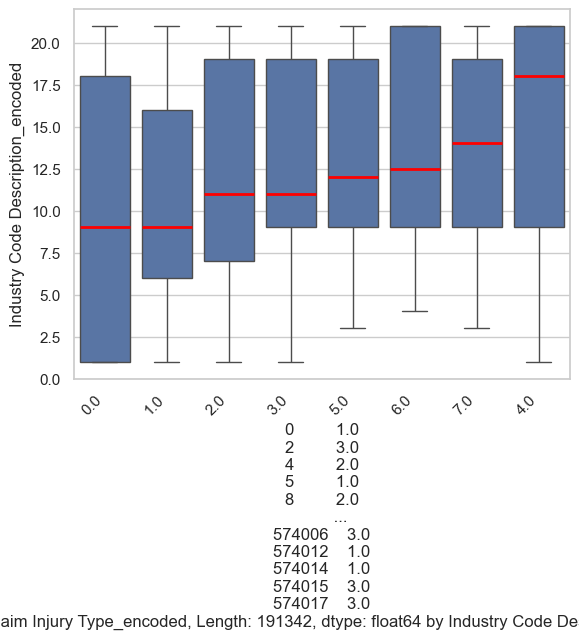

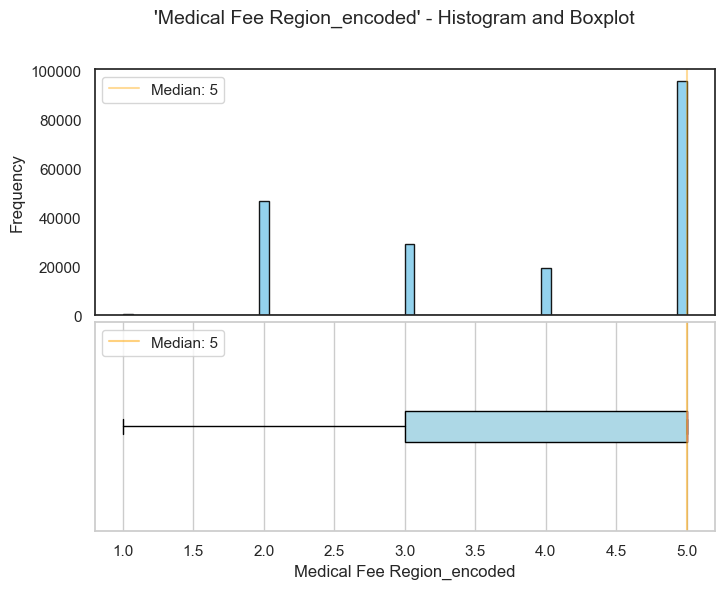

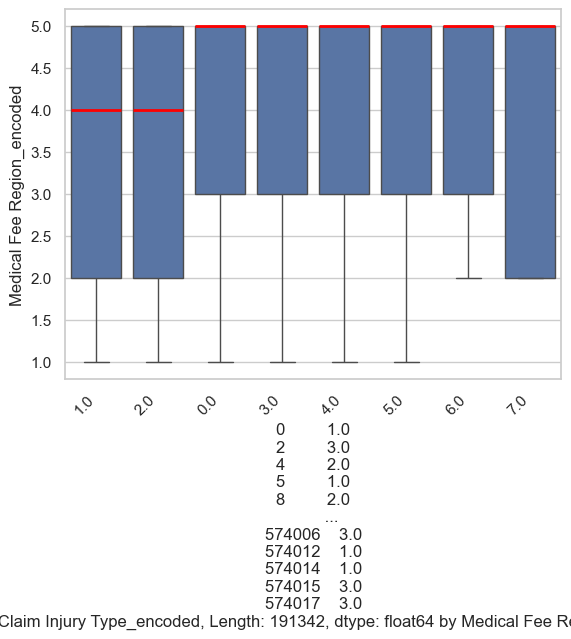

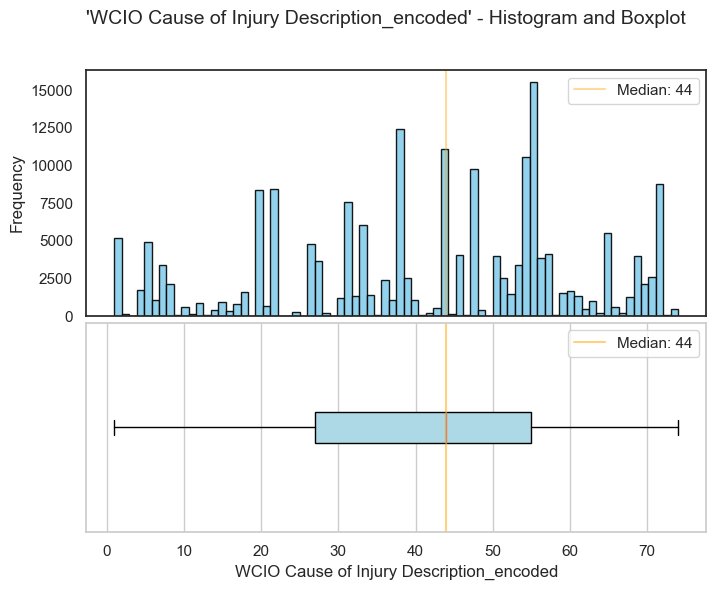

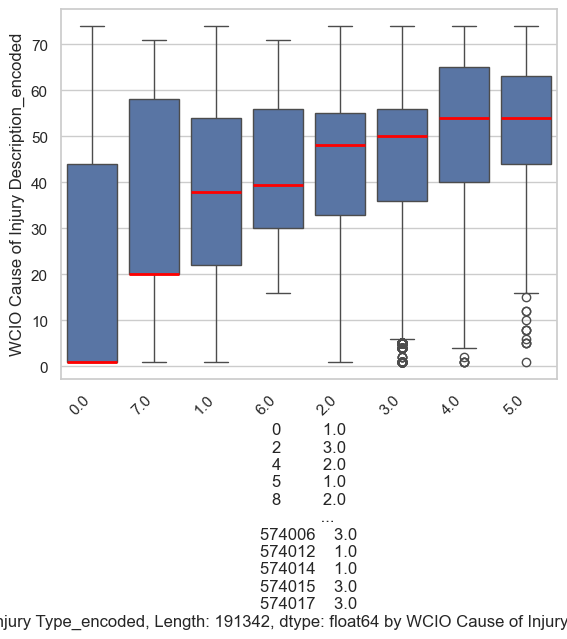

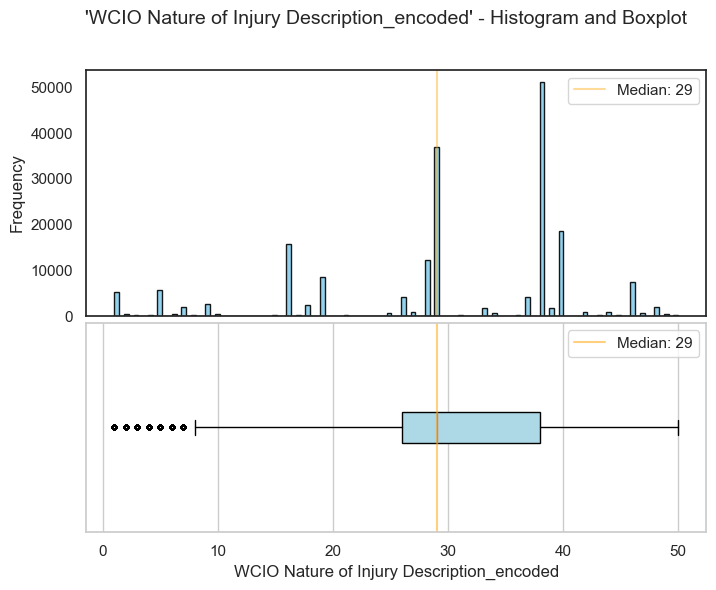

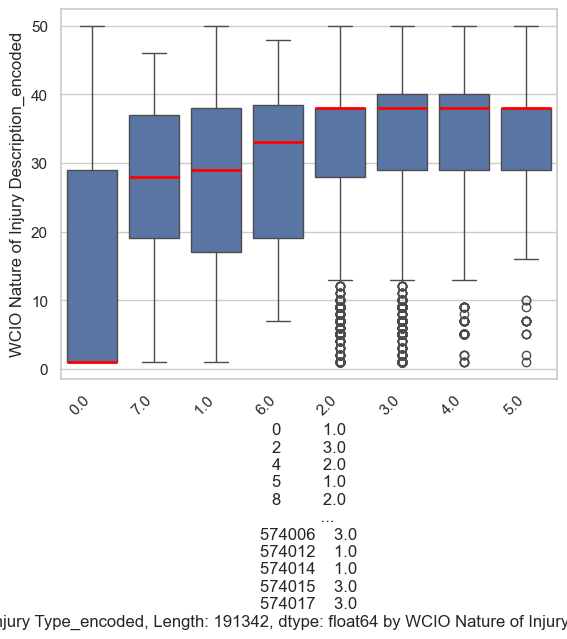

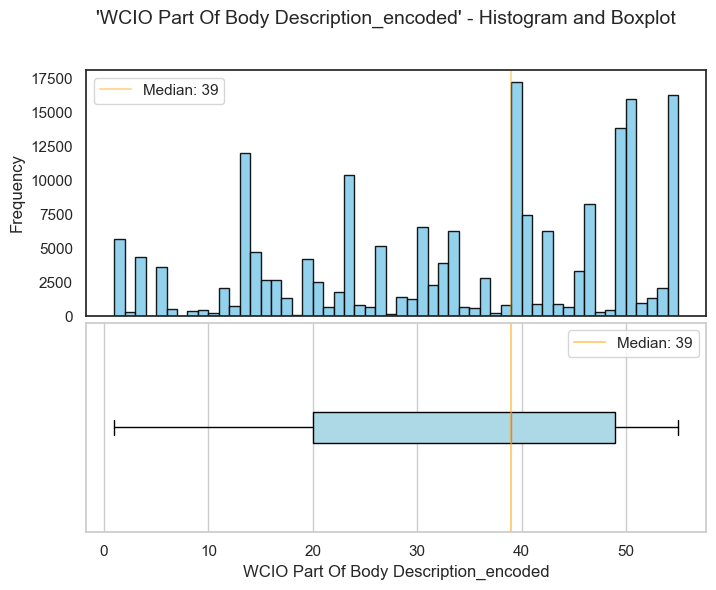

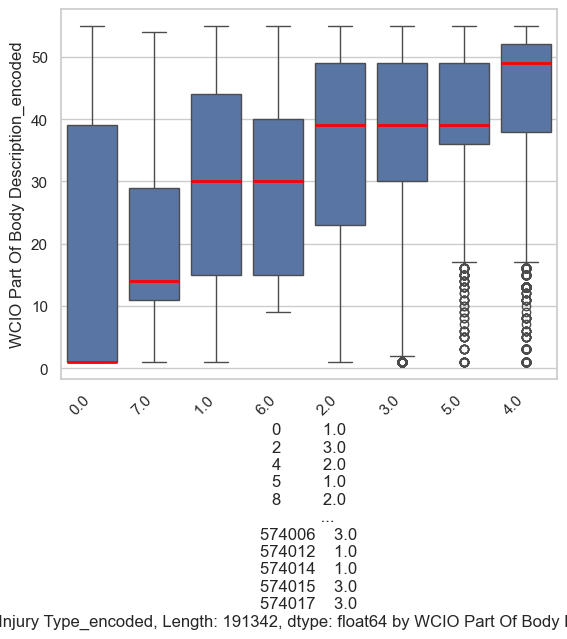

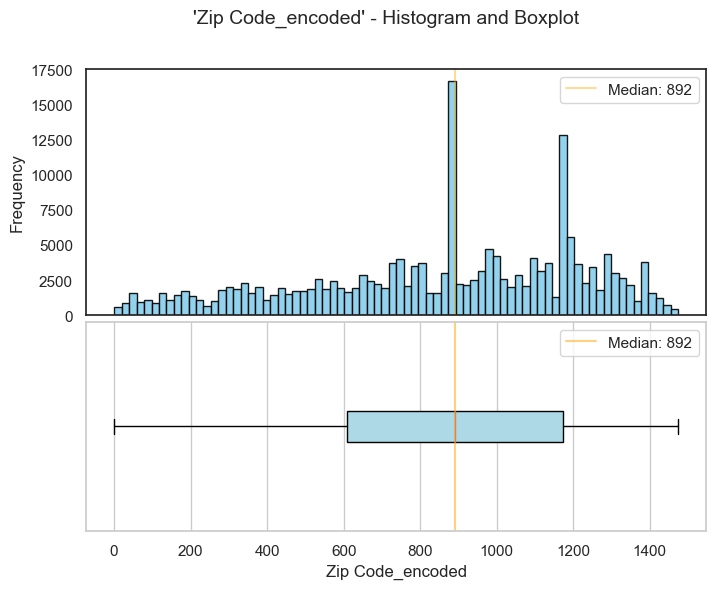

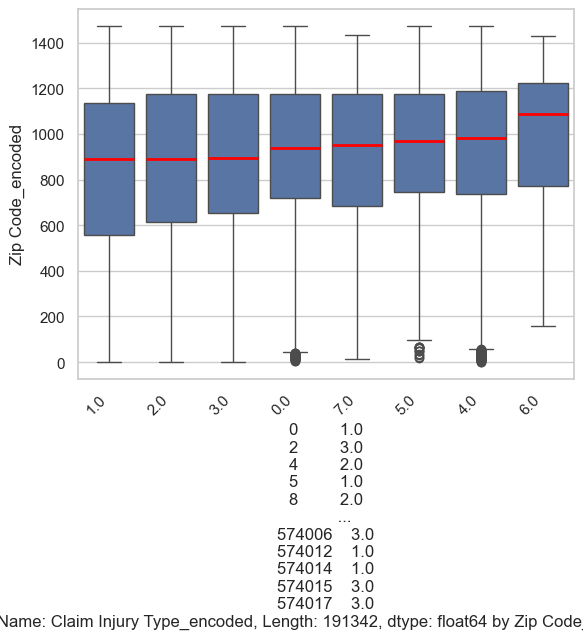

Frequency encoding...


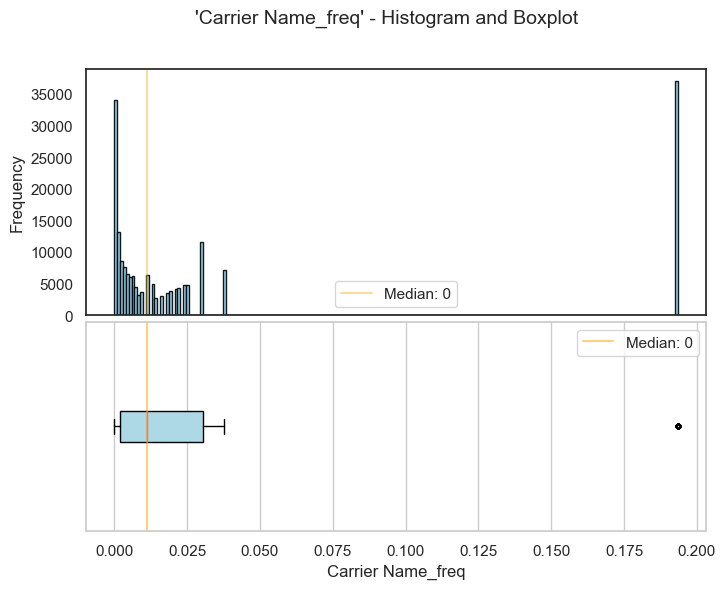

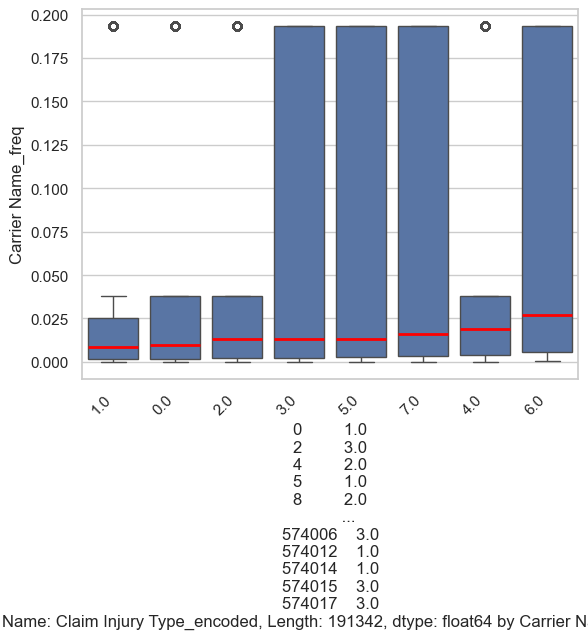

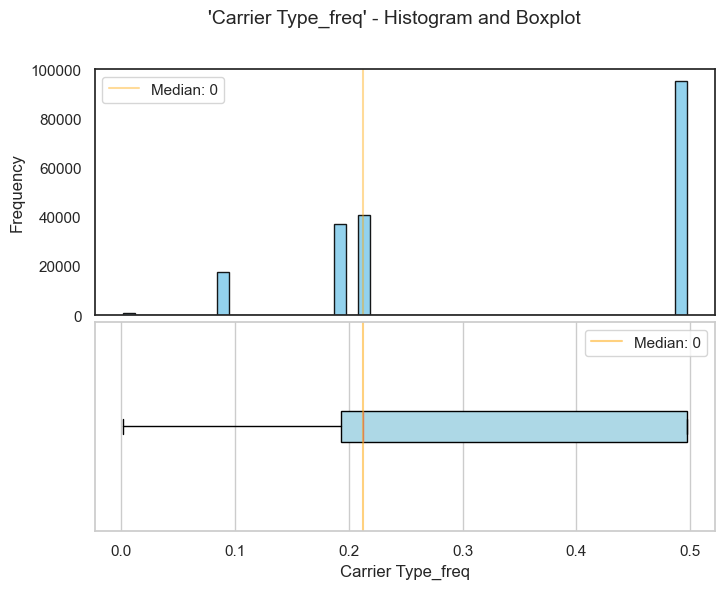

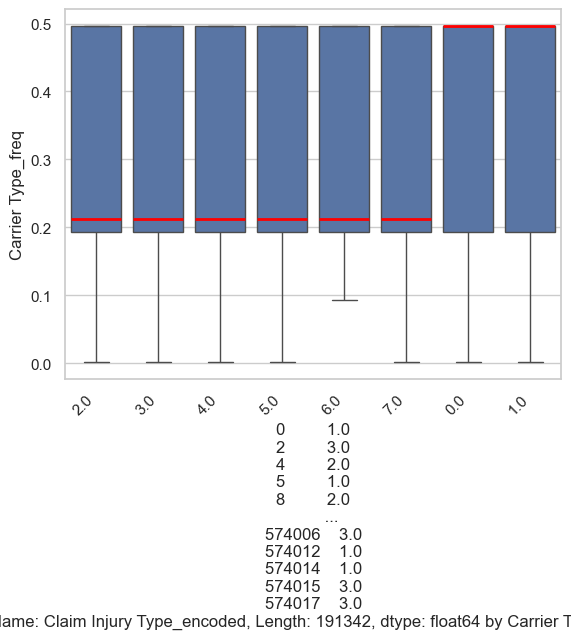

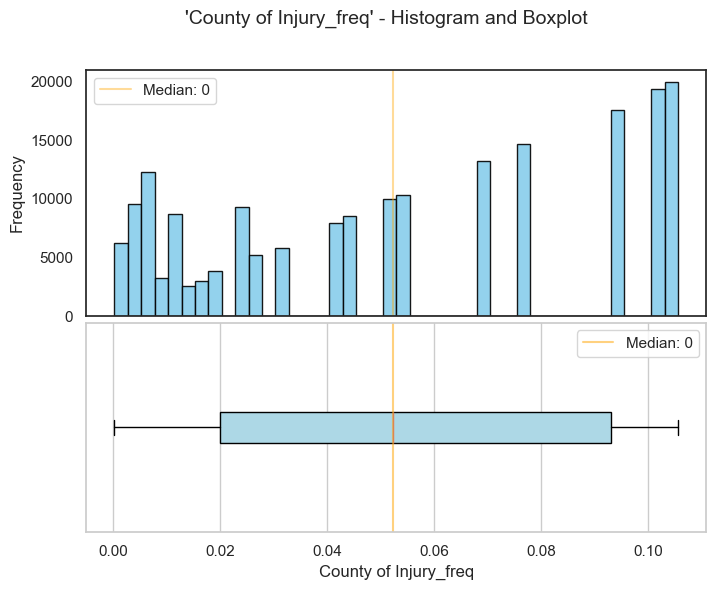

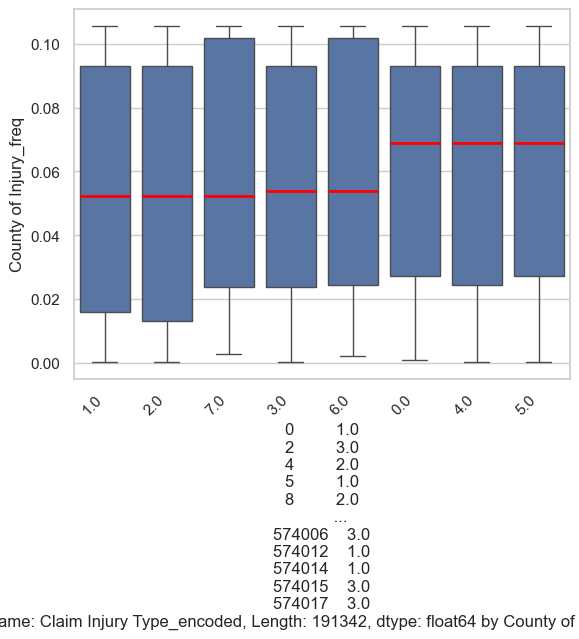

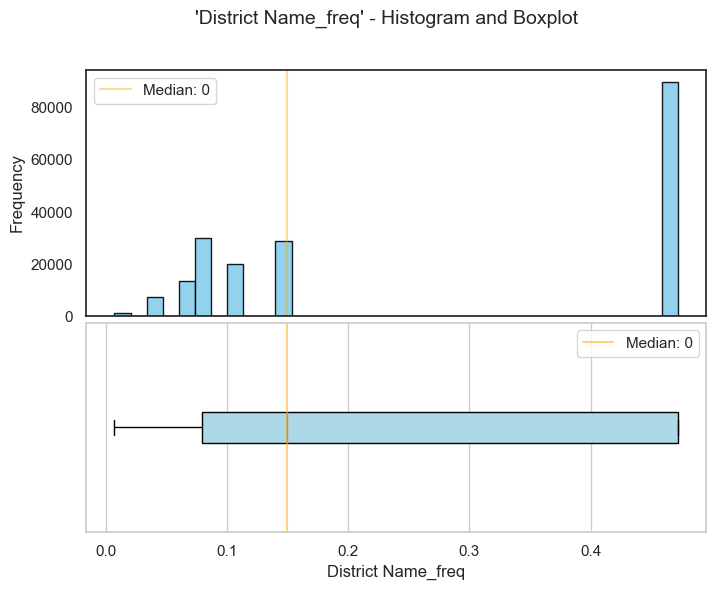

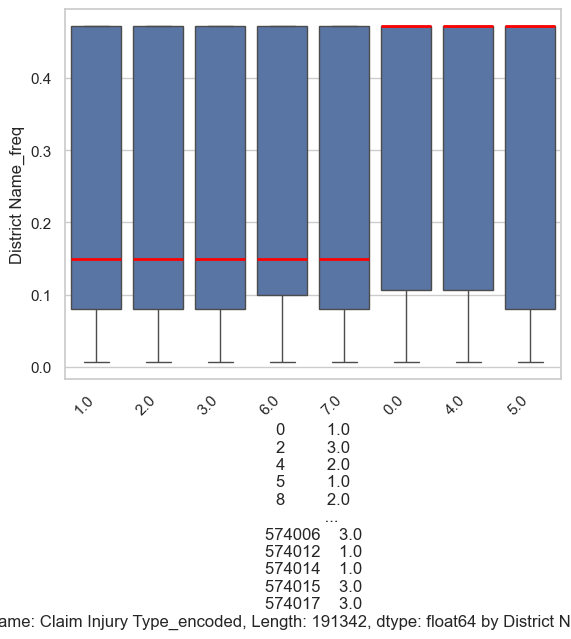

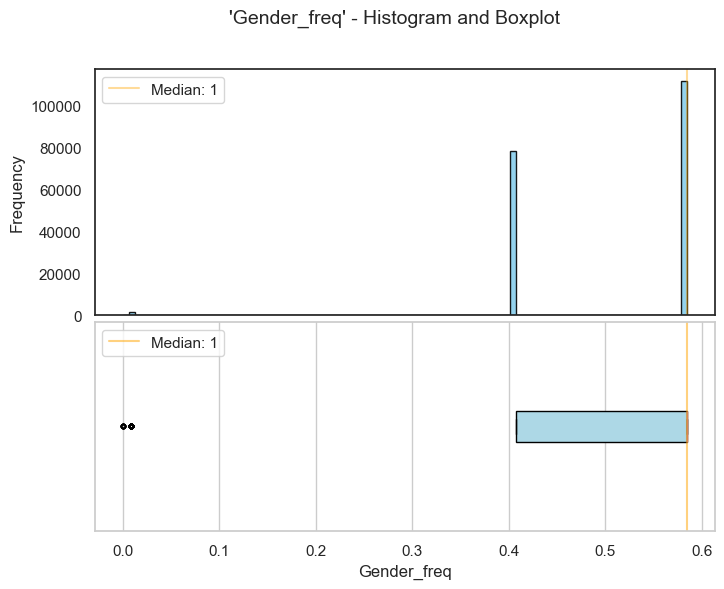

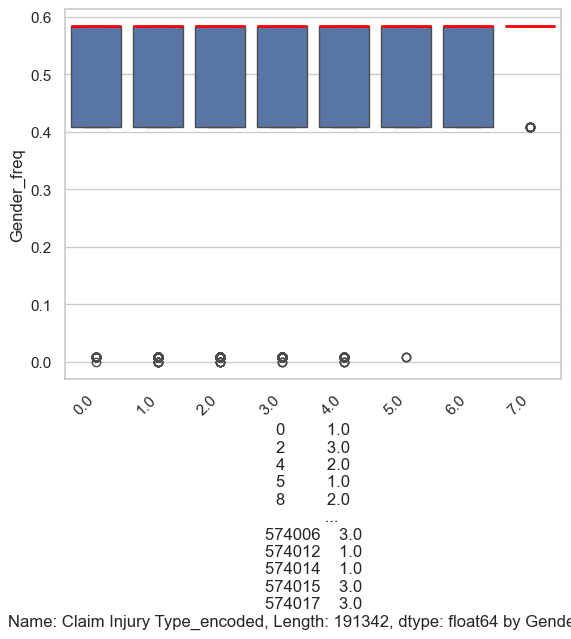

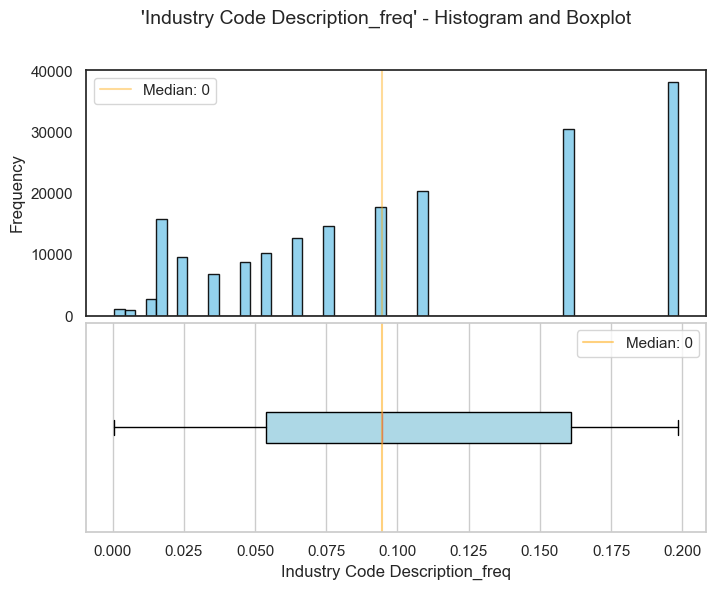

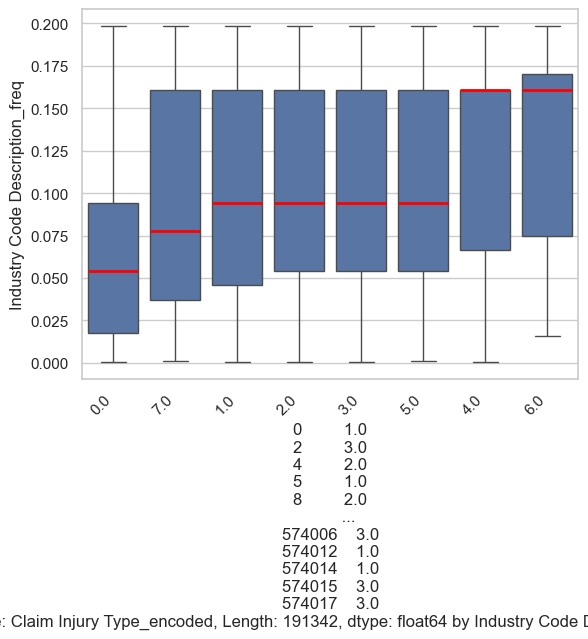

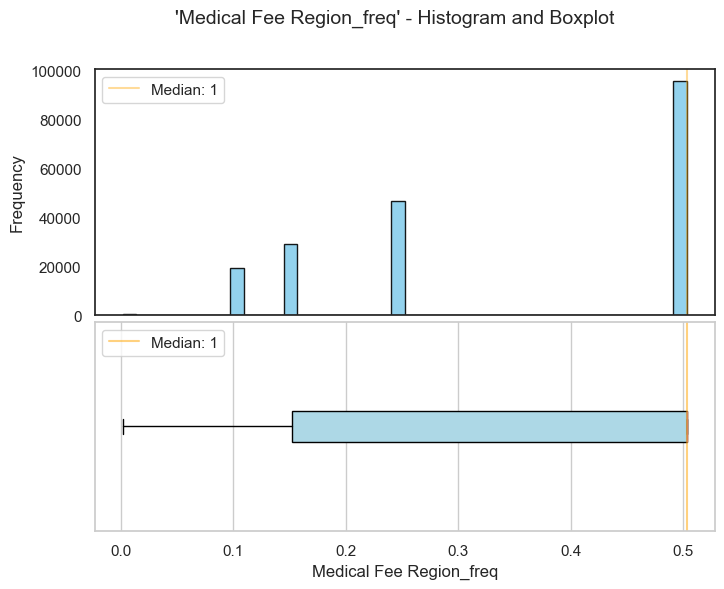

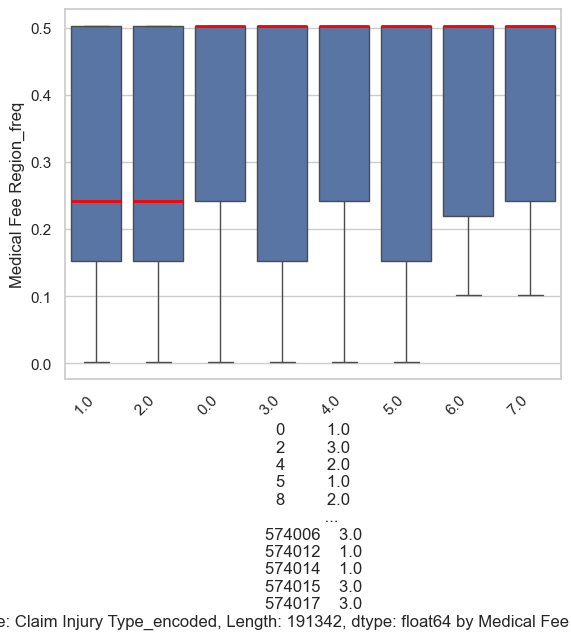

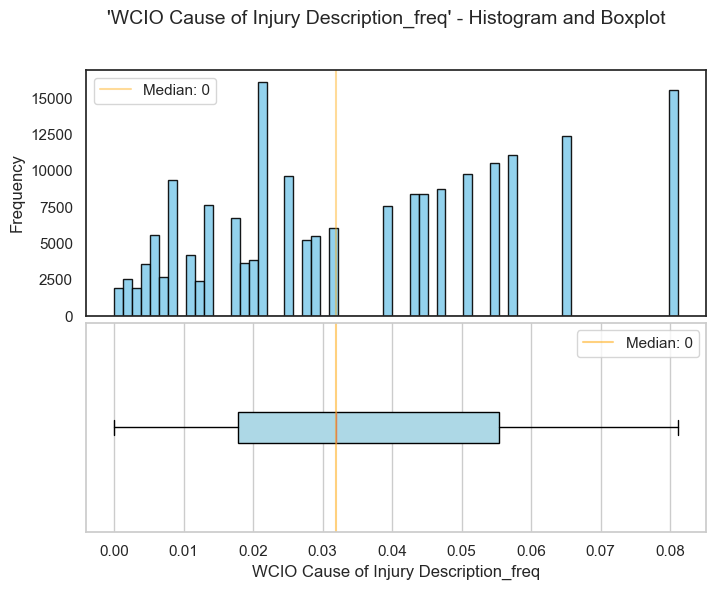

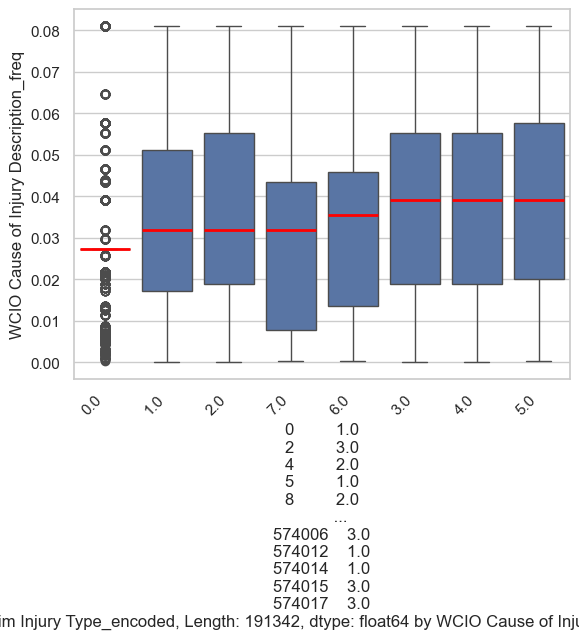

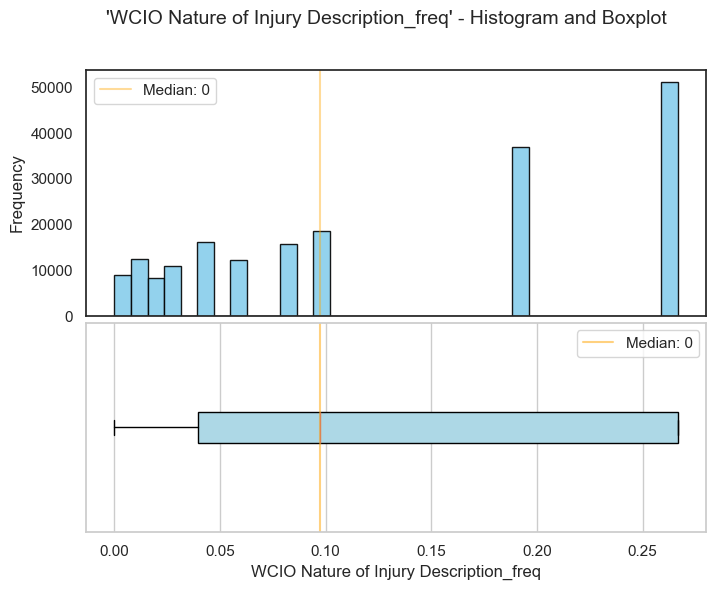

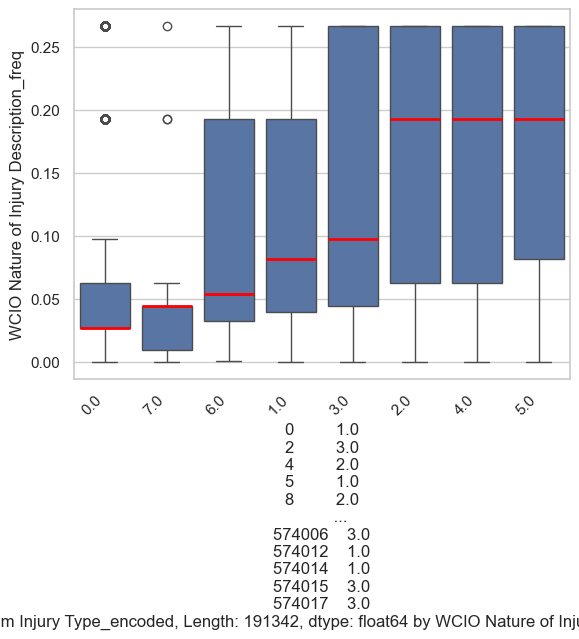

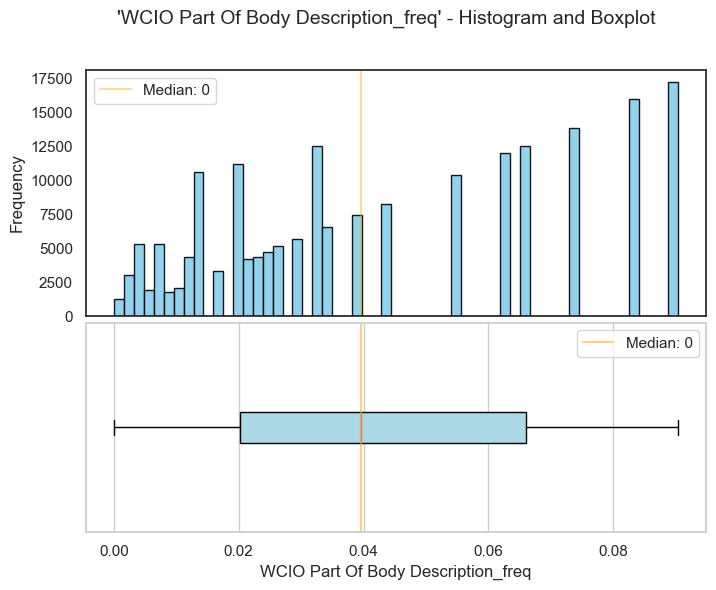

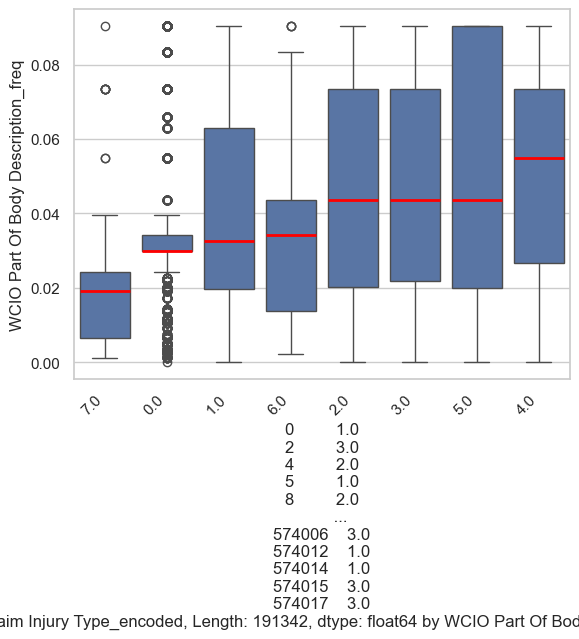

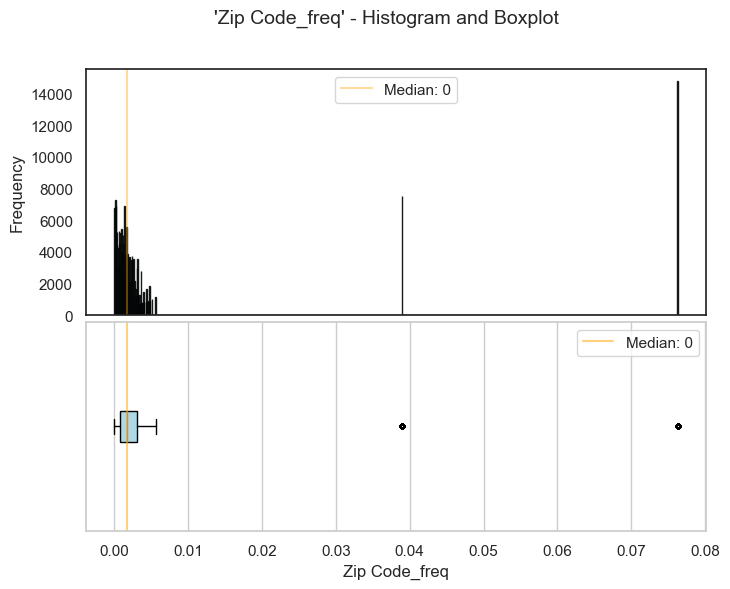

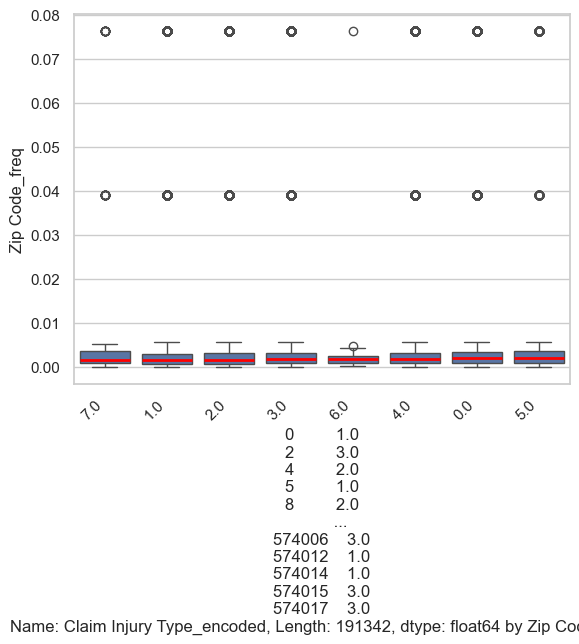

Impuiting missing values...
Redundant features to drop: ['Days from COVID', 'C2_Accident_gap_weeks', 'Hearing Date_missing', 'Hearing_assembly_gap_months', 'Gender_encoded']
Number of features after dropping redundant features: 46
RFE with 20 features testing...
Fitting estimator with 46 features.
Fitting estimator with 41 features.
Fitting estimator with 36 features.
Fitting estimator with 31 features.
Fitting estimator with 26 features.
Fitting estimator with 21 features.
RFE with 20 features is the best so far...
Train Score:  0.332
Validation Score:  0.331
RFE with 25 features testing...
Fitting estimator with 46 features.
Fitting estimator with 41 features.
Fitting estimator with 36 features.
Fitting estimator with 31 features.
Fitting estimator with 26 features.
RFE with 25 features is the best so far...
Train Score:  0.337
Validation Score:  0.337
RFE with 30 features testing...
Fitting estimator with 46 features.
Fitting estimator with 41 features.
Fitting estimator with 36 fea

[{'CV': 'CV_1',
  'Target': 'Ordinal_Encoded',
  'RFE Features': ['Attorney/Representative',
   'COVID-19 Indicator',
   'IME-4 Count',
   'Accident Date_year',
   'Accident Date_assembly_gap_days',
   'C3-C2_gap_days',
   'C2_missing',
   'C3_missing',
   'C3_Accident_gap_weeks',
   'Hearing_C3 gap_months',
   'Hearing_C2 gap_months',
   'Days to Assembly',
   'Days to First Hearing',
   'Average Weekly Wage_log',
   'Carrier Name_encoded',
   'Carrier Type_encoded',
   'Industry Code Description_encoded',
   'WCIO Cause of Injury Description_encoded',
   'WCIO Nature of Injury Description_encoded',
   'WCIO Part Of Body Description_encoded',
   'Carrier Name_freq',
   'Carrier Type_freq',
   'Industry Code Description_freq',
   'WCIO Nature of Injury Description_freq',
   'WCIO Part Of Body Description_freq'],
  'Validation Score': 0.33680616312347705},
 {'CV': 'CV_2',
  'Target': 'Ordinal_Encoded',
  'RFE Features': ['Alternative Dispute Resolution',
   'Attorney/Representative',
  

In [42]:
n_splits = 3
stratified_kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

feat_sel_results = []

for i, (train_index, val_index) in enumerate(stratified_kf.split(X, y_ordinal), start=1):
        print(f"Initializing CV_{i}/{n_splits}...")
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y_ordinal.iloc[train_index], y_ordinal.iloc[val_index]
        #y_binaries_train, y_binaries_val = y_binaries.iloc[train_index], y_binaries.iloc[val_index]

    
        #--------------- Target Ordinal Encoding 
        

        print(f"Ordinal encoding...")
        X_train_encoded = X_train.copy()
        X_val_encoded = X_val.copy()
        for cat in cat_feats:
            X_train_encoded, X_val_encoded, ordinal_mapping = target_guided_ordinal_encoding(X_train_encoded, X_val_encoded, cat, ordinal_target, y_train, 1)
            if i == 1:
                plot_numerical(X_val_encoded, f"{cat}_encoded")
                plot_numerical_vs_target(X_val_encoded, f"{cat}_encoded", y_val.squeeze())
        
        columns = X_train_encoded.columns

        # --------------- Target Encoding
        
        # num_feats = [feat for feat in X_train.columns if X_train[feat].dtype != "object"]
        # cat_feats = [feat for feat in X_train.columns if X_train[feat].dtype == "object" and X_train[feat].nunique()]
        
        # te = TargetEncoder(target_type="multiclass", smooth=0, random_state=42)
        # X_train_encoded,  = te.fit_transform(X_train[cat_feats], y_train), 
        # X_val_encoded = te.transform(X_val[cat_feats])
        # expanded_features = []
        # for feature in te.feature_names_in_:
        #     for i in range(1, 9):  
        #         expanded_features.append(f"{feature}_x_target_{i}")

        # print(expanded_features)
        # print(f"Total Features names   {len(expanded_features)} == transformed columns shape {X_train_encoded.shape[1]}")
        # X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=expanded_features, index=X_train.index)
        # X_val_encoded_df = pd.DataFrame(X_val_encoded, columns=expanded_features, index=X_val.index)
        
        # X_train_encoded = pd.concat([X_train[num_feats], X_train_encoded_df], axis=1)
        # X_val_encoded = pd.concat([X_val[num_feats], X_val_encoded_df], axis=1)
        
        # print(f"Final shape of the all features: {X_train_encoded.shape[1]}")
        
        # --------------- Frequency Encoding
        cat_feats = [feat for feat in X_train.columns if X_train[feat].dtype == "object"]
        print(f"Frequency encoding...")
        for cat in cat_feats:
            X_train_encoded, X_val_encoded, freq_map = frequency_encoding(X_train_encoded, X_val_encoded, cat)
            if i == 1:
                plot_numerical(X_val_encoded, f"{cat}_freq")
                plot_numerical_vs_target(X_val_encoded, f"{cat}_freq", y_val.squeeze())
        
        # --------------- Imputing missing values
        print(f"Impuiting missing values...")
        X_train_imputed, X_val_imputed = num_imputing(X_train_encoded, X_val_encoded)
        
        
        # ------------ Correlation (dropping redundant features)
        redundant_features_to_drop = cross_corr_mean(X_train_imputed, corr_coeff=0.90)
        print(f"Redundant features to drop: {redundant_features_to_drop}")
        X_train_imputed = X_train_imputed.drop(columns=redundant_features_to_drop)
        X_val_imputed = X_val_imputed.drop(columns=redundant_features_to_drop)
        
        print(f"Number of features after dropping redundant features: {X_train_imputed.shape[1]}")
        
        
        # ------------ Recursive Feature Elimination
        columns = X_train_imputed.columns
        group_sizes = [X_train_imputed.shape[1] // 4 * i for i in range(1, 10)]
        nof_list = np.arange(20, X_train_imputed.shape[1] + 1, 5)
        high_score = 0
        val_score = 0
        nof = 0
        
        for n in nof_list:
            if (n > nof + 10) & (val_score < high_score):
                break
            
            print(f"RFE with {n} features testing...")
            

            model = RandomForestClassifier(max_depth=6, random_state=42, n_jobs=-1, n_estimators=50, max_samples=0.8) 
                
            rfe = RFE(estimator=model, n_features_to_select=n, step=5, verbose = 1)
            
            X_train_rfe = rfe.fit_transform(X_train_imputed, y_train)
            X_val_rfe = rfe.transform(X_val_imputed)
                
            model.fit(X_train_rfe, y_train)
            
            train_predictions = model.predict(X_train_rfe)
            val_predictions = model.predict(X_val_rfe)
            
            train_score = f1_score(y_train, train_predictions, average="macro")
            val_score = f1_score(y_val, val_predictions, average="macro")
            
            if val_score > high_score or (val_score == 0 and n == nof_list[-1]):
                print(f"RFE with {n} features is the best so far...")
                print("Train Score: ", round(train_score, 3))
                print("Validation Score: ", round(val_score, 3))
                high_score = val_score
                nof = n

                features_to_select = pd.Series(rfe.support_, index=columns)
                RFE_feats = features_to_select[features_to_select].index.tolist()
        
        fine_steps =  np.arange(nof- 5, nof + 5, 3, dtype=int)
        fine_steps = [step for step in fine_steps if step != nof]        
        fine_steps = [step for step in fine_steps if step <= X_train_imputed.shape[1]]

        fine_steps
        for j in fine_steps:
            print(f"RFE with {j} features testing...")
            
            model = RandomForestClassifier(max_depth=6, random_state=42, n_jobs=-1, n_estimators=50, max_samples=0.8) 

            
            rfe = RFE(estimator=model, n_features_to_select=j, step=3, verbose=1)
        
            X_train_rfe = rfe.fit_transform(X_train_imputed, y_train)
            X_val_rfe = rfe.transform(X_val_imputed)
            
            model.fit(X_train_rfe, y_train)
            model.fit(X_train_rfe, y_train)
            
            train_probas = model.predict_proba(X_train_rfe)[:, 1]
            val_probas = model.predict_proba(X_val_rfe)[:, 1]
            
            train_predictions = model.predict(X_train_rfe)
            val_predictions = model.predict(X_val_rfe)
            
            train_score = f1_score(y_train, train_predictions, average="macro")
            val_score = f1_score(y_val, val_predictions, average="macro")
        
            if val_score > high_score:
                print(f"RFE with {j} features is the best so far - Train Score: {round(train_score, 3)} / Val Score: {round(val_score, 3)}")
                high_score = val_score
                nof = j

                features_to_select = pd.Series(rfe.support_, index=columns)
                RFE_feats = features_to_select[features_to_select].index.tolist()
                    
        feat_sel_results.append({
                    "CV": f"CV_{i}",
                    "Target": "Ordinal_Encoded",
                    "RFE Features": RFE_feats,
                    "Validation Score": high_score
                })
        print(f"Best RFE Features: {RFE_feats}")
        print(f"Best Validation Score: {high_score} with {nof} features")
        print(f"Classification Report: {classification_report(y_val, val_predictions)}")
        print("--------------------------------------------------")
    
feat_sel_results

In [43]:
all_features = []
for result in feat_sel_results:
    all_features.extend(result['RFE Features'])

feature_counts = Counter(all_features)

selected_features = [feature for feature, count in feature_counts.items() if count >= 2]

selected_features

['Attorney/Representative',
 'IME-4 Count',
 'Accident Date_year',
 'Accident Date_assembly_gap_days',
 'C3-C2_gap_days',
 'C2_missing',
 'C3_missing',
 'C3_Accident_gap_weeks',
 'Hearing_C3 gap_months',
 'Hearing_C2 gap_months',
 'Days to Assembly',
 'Days to First Hearing',
 'Average Weekly Wage_log',
 'Carrier Name_encoded',
 'Carrier Type_encoded',
 'Industry Code Description_encoded',
 'WCIO Cause of Injury Description_encoded',
 'WCIO Nature of Injury Description_encoded',
 'WCIO Part Of Body Description_encoded',
 'Carrier Name_freq',
 'Carrier Type_freq',
 'Industry Code Description_freq',
 'WCIO Nature of Injury Description_freq',
 'WCIO Part Of Body Description_freq']